# Carregamento dos dados

In [1]:
from pandas import read_csv

url = "./SA_heart.csv"
dataset = read_csv(url, header=0, usecols=[i+1 for i in range(10)])

dataset.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Preparação dos dados

### Extração de entradas e saídas, conversão da dataframe para numpy array


In [2]:
import numpy as np

# extração da variável a ser predita
y = np.array(dataset['chd'])
dataset = dataset.drop('chd', axis=1)

# armazenamento do nome de cada variável preditora para uso futuro
X_names = list(dataset.columns)

# conversão para numpy array
X = np.array(dataset)

# Análise estatística inicial dos dados

### Quantidades médias

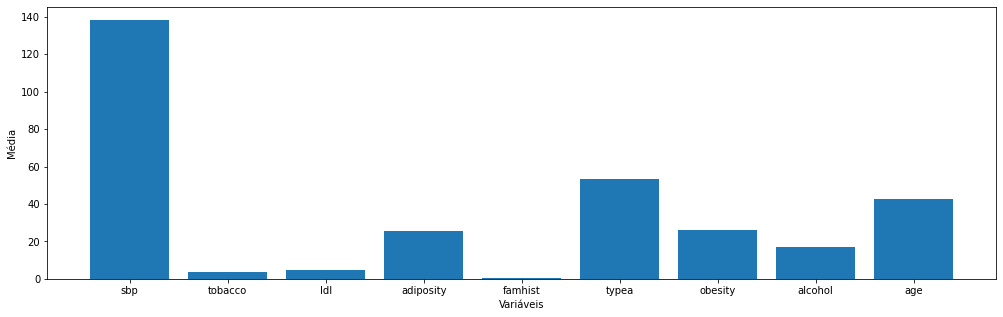

In [3]:
from matplotlib import pyplot

pyplot.figure(figsize=(17,5))
pyplot.bar([i+1 for i in range(9)], [f.mean() for f in X.transpose()], tick_label=X_names, width=0.8)
pyplot.xlabel('Variáveis')
pyplot.ylabel('Média')
pyplot.show()

### Desvio padrão

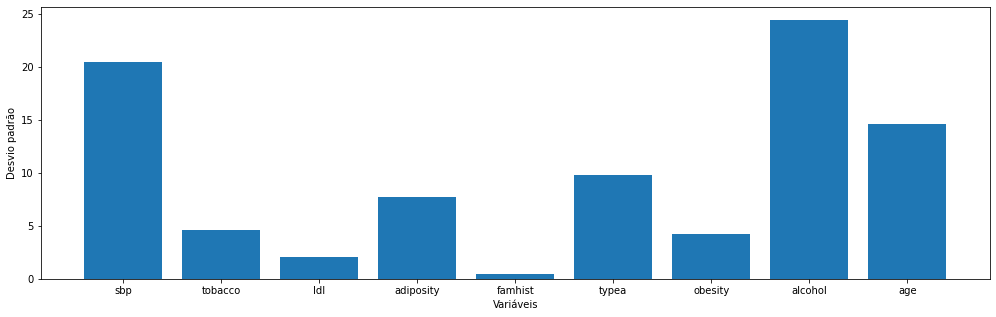

In [4]:
pyplot.figure(figsize=(17,5))
pyplot.bar([i+1 for i in range(9)], [f.std() for f in X.transpose()], tick_label=X_names, width=0.8)
pyplot.xlabel('Variáveis')
pyplot.ylabel('Desvio padrão')
pyplot.show()

# Função de avaliação dos modelos

Serão realizadas duas avaliações:
<ol>
    <li>Gráfico contendo a curva ROC AUC de cada um dos modelos gerados pela validação cruzada (além da curva média).</li>
    <li>Matriz de confusão média.</li>
</ol>

In [5]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, auc
from sklearn.model_selection import StratifiedKFold

def evaluate(model):
    # validação cruzada em 10 rodadas com 10% dos dados separados para teste
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    
    # instanciação plot ROC AUC
    fig, ax = pyplot.subplots(figsize=(12.4,9.6))
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    
    # instanciação da matriz de confusão
    mean_cm = np.array([[0, 0],
                  [0, 0]], dtype='float')
    
    # iteração entre todos os subconjuntos de dados
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        # treinamento do modelo 
        model.fit(X[train], y[train])
        
        # matriz de confusão
        cm = confusion_matrix(y[test], model.predict(X[test]))
        mean_cm += cm/10
        
        # curva ROC do subconjunto atual
        display = RocCurveDisplay.from_estimator(model, X[test], y[test], name='ROC fold {}'.format(i+1), ax=ax)
        interp_tpr = np.interp(mean_fpr, display.fpr, display.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(display.roc_auc)
    
    # curva-base (50-50) 
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    
    # curva média 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    
    # desvio padrão entre as 10 curvas ROC
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC AUC Curve")
    ax.legend(loc="lower right") 
    pyplot.show()
    
    # plotagem da matriz de confusão média
    display = ConfusionMatrixDisplay(mean_cm)
    display.plot()
    pyplot.title("Confusion matrix")
    pyplot.show() 

# Algoritmos

## 1 - Árvore de decisão (ID3)

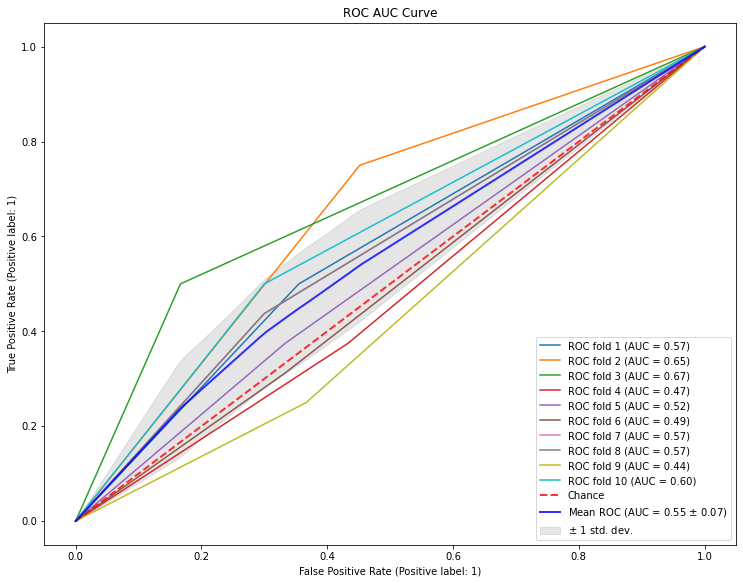

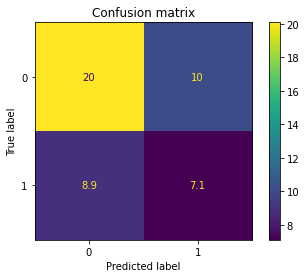

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# instanciação do modelo
model = DecisionTreeClassifier(criterion='entropy')

# avaliação
evaluate(model)

## 2 - Floresta randômica (utilizando todas as variáveis preditoras

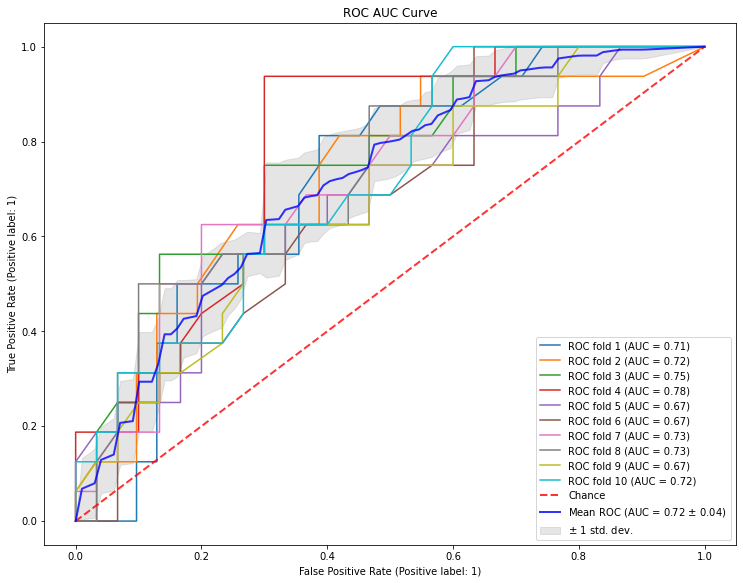

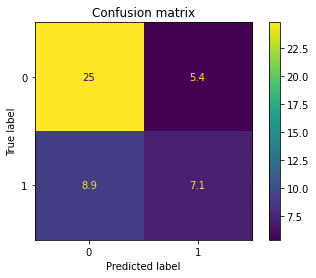

In [7]:
from sklearn.ensemble import RandomForestClassifier

# instanciação do modelo
# com 100 árvores ID3
model = RandomForestClassifier(
    criterion='entropy', n_estimators=100, max_features=9)

# avaliação
evaluate(model)

## 2 - Floresta randômica (utilizando o quadrado das variáveis preditoras

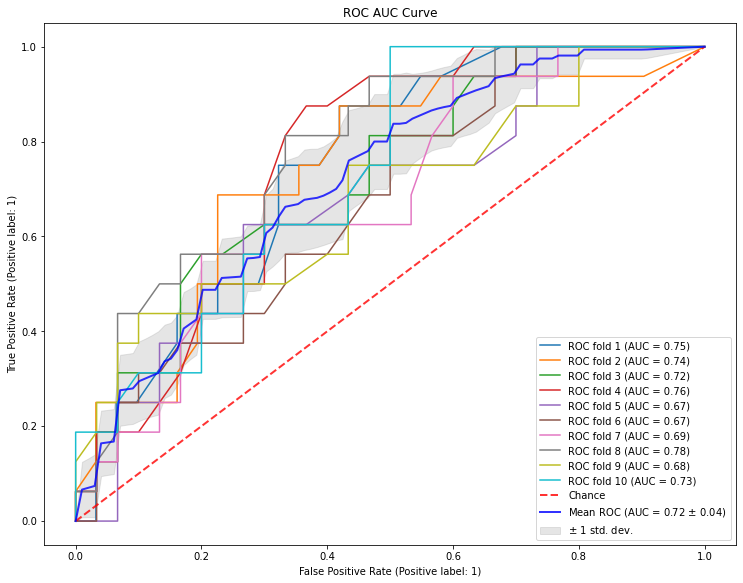

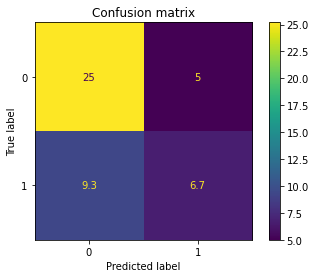

In [8]:
# instanciação do modelo
# com 100 árvores (ID3)
model = RandomForestClassifier(
    criterion='entropy', n_estimators=100, max_features=3)

# avaliação
evaluate(model)

## Variáveis mais importantes

Impressão das duas variáveis mais importantes do modelo mais efetivo (floresta randômica com o quadrado das variáveis).

In [9]:
# Impressão das duas variáveis mais importantes
# fonte: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# lista numérica de variáveis mais importantes gerada pelo scikitlearn 
importances = list(model.feature_importances_)

# lista de tuplas com nomes da variável e sua importancia
X_importances = [(X, round(importance, 2)) for X, importance in zip(X_names, importances)]

# ordenação
X_importances = sorted(X_importances, key = lambda x: x[1], reverse = True)

# impressão das duas variáveis mais importantes
for par in X_importances[:2]:
    print('{:20} Importância: {}'.format(*par))

tobacco              Importância: 0.15
age                  Importância: 0.15
ldl                  Importância: 0.13
adiposity            Importância: 0.13
typea                Importância: 0.12
obesity              Importância: 0.11
sbp                  Importância: 0.1
alcohol              Importância: 0.07
famhist              Importância: 0.04
